In [42]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from customer_segmentation.utils import functions
importlib.reload(functions)

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

In [2]:
# import data
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
file_name = 'cohort_data.csv'
file_path = os.path.join(data_dir, file_name)

cohort = pd.read_csv(file_path)

In [3]:
cohort.head()

,user_id,age,has_children,is_married,cnt_trips,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_flight_travel_days,avg_distance_km,avg_rooms,avg_hotel_nights,min_signup_date,days_active,avg_session_duration_seconds,has_flight_booked,has_hotel_booked,avg_flight_discount,avg_hotel_discount,month_active,sessions_per_month,trips_per_month,page_click_per_session,avg_booking_value,customer_value_per_month,total_discount_rate,discount_per_km,cancellation_rate
0,264579,26,0,0,2,26.0,247,8.0,4.0,1.0,4.0,877.0,1.0,3.0,2022-07-28,273,129.0,1,1,0.15,0.13,9.100000,0.879121,0.219780,17.500000,1348.575,296.390110,0.00,0.00000,0.0
1,264581,21,1,0,1,0.0,335,5.0,8.0,0.0,0.0,0.0,1.0,8.0,2022-07-28,347,63.0,0,1,0.13,0.08,11.566667,0.605187,0.086455,8.428571,1320.000,114.121037,0.05,NaN,0.0
2,264582,42,0,1,3,107.0,110,7.0,4.0,1.0,4.0,2533.0,1.0,3.0,2022-07-28,323,216.0,1,1,0.15,0.10,10.766667,0.650155,0.278638,29.285714,623.610,173.761300,0.00,0.00000,0.0
3,264584,46,0,1,4,54.0,60,9.0,5.0,1.0,5.0,3279.0,1.0,4.0,2022-07-28,223,149.0,1,1,0.08,0.00,7.433333,1.076233,0.538117,20.000000,929.670,500.270852,0.01,0.00264,0.0
4,264586,50,1,1,5,66.0,17,6.0,5.0,1.0,6.0,2034.0,1.0,4.0,2022-07-28,281,198.0,1,1,0.00,0.00,9.366667,0.640569,0.533808,26.500000,469.086,250.401779,0.00,0.00000,0.0


In [4]:
# convert data types
cohort['user_id'] = cohort['user_id'].astype(str)
cohort['cnt_trips'] = cohort['cnt_trips'].astype(int)
cohort['min_signup_date'] = pd.to_datetime(cohort['min_signup_date'])

In [31]:
# Recency: days_last_trip
# Frequency: trips_per_month
# Monetary: customer_value_per_month

cohort['min_signup_yearmonth'] = cohort['min_signup_date'].dt.strftime('%Y-%m')

cohort['R_score'] = pd.qcut(cohort['days_last_trip'], q=5, labels=[5, 4, 3, 2, 1])
cohort['F_score'] = pd.qcut(cohort['trips_per_month'], q=5, labels=[1, 2, 3, 4, 5])
cohort['M_score'] = pd.qcut(cohort['customer_value_per_month'], q=5, labels=[1, 2, 3, 4, 5])

cohort['RFM_score'] = cohort[['R_score','F_score','M_score']].astype(int).sum(axis=1)


In [40]:
conditions = [
    (cohort['RFM_score'] >= 13),
    (cohort['RFM_score'] >= 10) & (cohort['RFM_score'] < 13),
    (cohort['RFM_score'] >= 7)  & (cohort['RFM_score'] < 10),
    (cohort['RFM_score'] >= 4)  & (cohort['RFM_score'] < 7),
    (cohort['RFM_score'] < 4),
]

labels = [
    'Champions',
    'Loyal Customers',
    'Potential Loyalists',
    'At risk',
    'Lost',
]

cohort['RFM_groups'] = np.select(conditions, labels, default='Unknown')
cohort['RFM_groups'] = cohort['RFM_groups'].astype('category')
cohort['RFM_groups'] = cohort['RFM_groups'].cat.reorder_categories(labels, ordered=True)

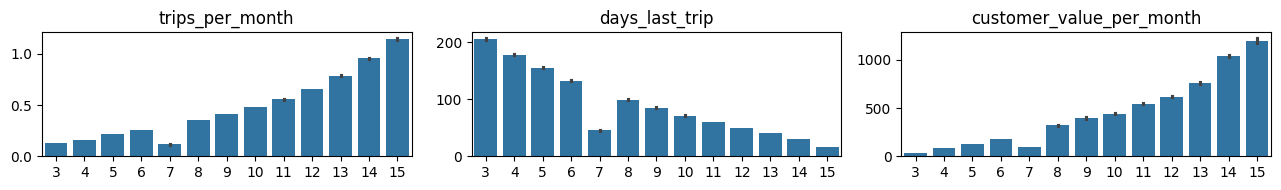

In [46]:
metrics = ['trips_per_month', 'days_last_trip', 'customer_value_per_month']

functions.plot_bivariate_series(df=cohort, category='RFM_score', metrics=metrics, n_cols=3)

In [41]:
grouped_cohort = cohort.groupby('RFM_groups', observed=True).agg(
    cnt_user = ('user_id', 'nunique'),
    days_last_trip = ('days_last_trip', 'mean'),
    trips_per_month = ('trips_per_month', 'mean'),
    customer_value_per_month = ('customer_value_per_month', 'mean'),  
    
).reset_index()
grouped_cohort

,RFM_groups,cnt_user,days_last_trip,trips_per_month,customer_value_per_month
0,Champions,27962,33.322545,0.903758,933.455232
1,Loyal Customers,44866,60.518410,0.562958,531.821567
2,Potential Loyalists,67117,66.927306,0.240103,218.581473
3,At risk,28786,150.400577,0.220676,140.340981
4,Lost,3624,205.661700,0.127987,37.716792


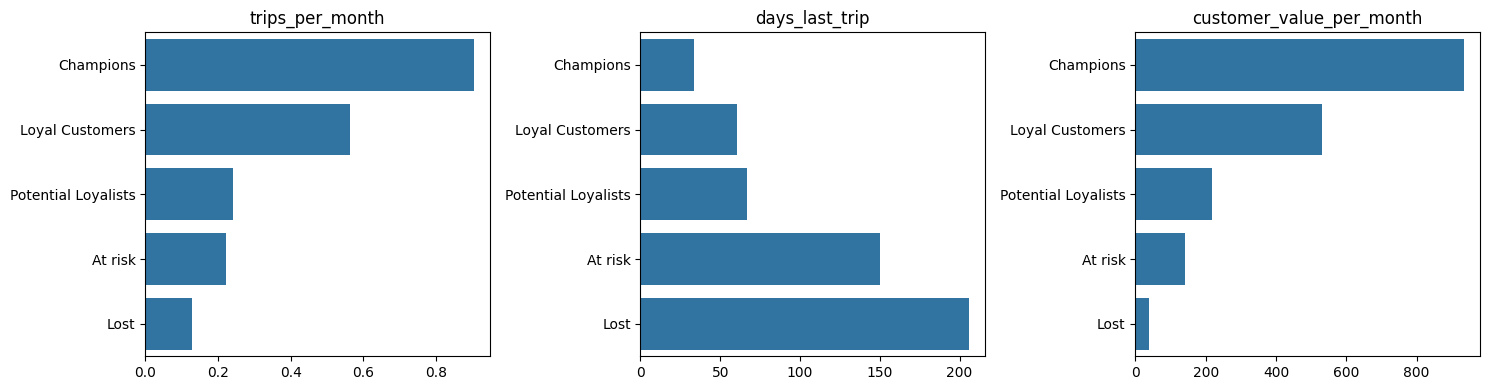

In [66]:
metrics = ['trips_per_month', 'days_last_trip', 'customer_value_per_month']
_, axes = plt.subplots(1, 3, figsize = (15, 4))
axes = axes.flatten()
for i, col in enumerate(metrics):
    sns.barplot(data=grouped_cohort, x=col, y='RFM_groups', ax = axes[i])  
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
plt.tight_layout()
plt.show()